In [1]:
# visualization
from ast import Str
from cProfile import label
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random as rnd
import os


# machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from pandas.plotting import scatter_matrix
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
df=pd.read_csv('../input/breast-cancer-wisconsin-data/data.csv')
df=df.drop(["Unnamed: 32"],axis=1)

In [3]:

sns.set_theme(style="darkgrid")
def label_encoder(column):
       encoder = preprocessing.LabelEncoder()
       encoder.fit(column)
       le=encoder.transform(column)
       return le
drop_columns=['id','radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst',
'fractal_dimension_worst']
df.drop(drop_columns, axis=1, inplace = True)

# Reset index of dataframe
df = df.reset_index(drop = True)


In [4]:
encoder = LabelEncoder()
# Apply encoder on column 'diagnosis'
df['diagnosis'] = df[['diagnosis']].apply(encoder.fit_transform)


# Take copy of the dataset
df_copy = df.copy(deep = True)

# Create X (feature set) and y (target) variables
X = df.drop(['diagnosis'],axis=1)
y = df['diagnosis'].to_frame()

# Create X_copy variable
X_copy = df_copy.drop(['diagnosis'],axis=1)


In [5]:
# Instantiate Stander Scaler and fit and tranform feature variable set X
scaler = StandardScaler(copy = True, with_mean = True, with_std = True)
X_copy_scaled = pd.DataFrame(scaler.fit_transform(X_copy), columns=X_copy.columns)

In [6]:
# Reduce dimensions on the scaled dataset using PCA with 95% variance retained
pca = PCA(n_components = 0.95)
pca.fit(X_copy_scaled)
X_copy_scaled = pca.transform(X_copy_scaled)
X_copy_scaled = pd.DataFrame(X_copy_scaled)


In [7]:
# Import libraries for Model training, prediction and evaluation
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import xgboost as xgb


In [8]:
# Split Data into Train and Test sets with 80% of data as Train set and 20% as Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_copy_scaled, y, test_size = 0.2, random_state=0)

In [9]:
# Function to fit classifier and print Accuracy score
def model(classifier, X_train, y_train,
                             X_test, y_test, X = X, y = y):
    classifier.fit(X_train,np.ravel(y_train))
    y_pred = classifier.predict(X_test)
    
    print("Model: ",type(classifier).__name__)
    print("Test Data Accuracy: %0.2f" % accuracy_score(y_test,y_pred))


In [10]:
# Train and fit Decision Tree classifier
clf_dct = DecisionTreeClassifier()
model(clf_dct, X_train, y_train, X_test, y_test)

# Train and fit SVC classifier
clf_svc = SVC()
model(clf_svc, X_train, y_train, X_test, y_test)

# Train and fit XGB classifier
clf_xgb = xgb.XGBClassifier()
model(clf_xgb, X_train, y_train, X_test, y_test)



Model:  DecisionTreeClassifier
Test Data Accuracy: 0.92
Model:  SVC
Test Data Accuracy: 0.88
Model:  XGBClassifier
Test Data Accuracy: 0.96


In [11]:
# Function to fit classifier, perform K-Fold Cross validation print Accuracy score and confusion matrix
def model_hypertuning(classifier, params, X_train, y_train,X_test, y_test, X = X, y = y):
                 classifier.set_params(**params)
                 classifier.fit(X_train,np.ravel(y_train))
                 y_pred = classifier.predict(X_test)
                 print("Model: ",type(classifier).__name__)
                 print("Test Data Accuracy: %0.2f" % accuracy_score(y_test,y_pred))
                 print("K-Fold Cross Validation Accuracy: %0.2f" % cross_val_score(classifier, X, np.ravel(y), scoring='accuracy', cv=5).mean())
                 print("Confusion Matrix:")
                 disp = ConfusionMatrixDisplay.from_estimator( classifier,X_test,y_test,
                          display_labels=classifier.classes_, cmap=plt.cm.Blues)
                 print(disp.confusion_matrix)
                 plt.grid(False)
                 plt.show()


Model:  DecisionTreeClassifier
Test Data Accuracy: 0.94
K-Fold Cross Validation Accuracy: 0.91
Confusion Matrix:
[[64  3]
 [ 4 43]]


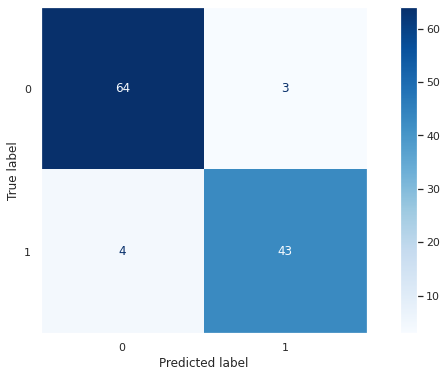

In [12]:
#################### Decision Tree Classifier #############################
clf_dct = DecisionTreeClassifier()

params = { 'max_depth' : [3,5,10,15,20,25,30,35,40,45,50],
          'criterion' : ["gini","entropy"],
          'max_features' : ['auto', 'sqrt', 'log2'],
          'min_samples_split' : [2,4,6,8,10]
         }

grid = RandomizedSearchCV(clf_dct, params, n_jobs=-1)
grid.fit(X_train, np.ravel(y_train))

model_hypertuning(clf_dct,grid.best_params_,X_train, y_train, 
                         X_test, y_test)    

############################################################################


Model:  SVC
Test Data Accuracy: 0.91
K-Fold Cross Validation Accuracy: 0.89
Confusion Matrix:
[[60  7]
 [ 3 44]]


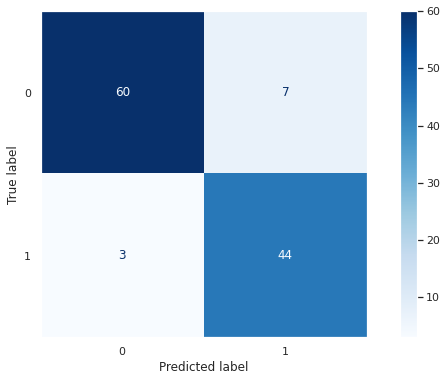

In [13]:
########################## SVC Classifier ##################################
clf_svc = SVC()

params = { 'kernel' : ['linear','rbf','poly','sigmoid'],
          'C' : [0.1,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5],
          'degree' : [1,2,3,4,5,6]
         }
grid = RandomizedSearchCV(clf_svc, params, n_jobs=-1)
grid.fit(X_train_scaled, np.ravel(y_train_scaled))

model_hypertuning(clf_svc,grid.best_params_,X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)
############################################################################



Model:  XGBClassifier
Test Data Accuracy: 0.96
K-Fold Cross Validation Accuracy: 0.95
Confusion Matrix:
[[65  2]
 [ 3 44]]


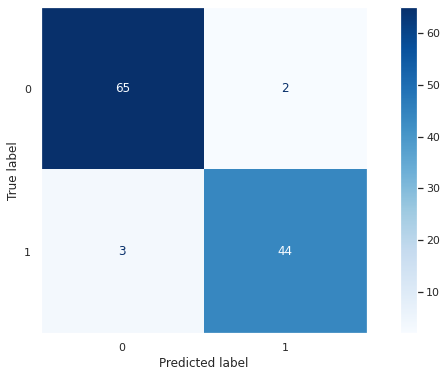

In [14]:
#################### XG Boost Classifier ###################################
clf_xgb = xgb.XGBClassifier()

params = { 'learning_rate' : [0.05,0.1,0.15,0.2,0.25,0.3],
          'max_depth' : [3,4,5,6,8,10,12,16],
          'min_child_weight' : [1,3,5,7],
          'gamma' : [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4],
          'colsample_bytree' : [0.3,0.4,0.5,0.6]
         }
grid = RandomizedSearchCV(clf_xgb, params, n_jobs=-1)
grid.fit(X_train, np.ravel(y_train))

model_hypertuning(clf_xgb,grid.best_params_,X_train, y_train, X_test, y_test)
#############################################################################        